In [1]:
import sys
sys.path.append('diffusion/stable_diffusion/')
sys.path.append('diffusion/stable_diffusion/model/')
sys.path.append('lib/src/')
import torch
from torch import nn
import os
import numpy as np
from matplotlib import pyplot as plt

from diffusion.stable_diffusion.latent_diffusion import LatentDiffusion, DiffusionWrapper
from diffusion.stable_diffusion.model.autoencoder import Autoencoder
from diffusion.stable_diffusion.model.clip_embedder import CLIPTextEmbedder
from diffusion.stable_diffusion.model.unet import UNetModel, _test_time_embeddings


from lib.src.pythae.models import LVAE_IAF, LVAE_IAF_Config, AutoModel
from lib.src.pythae.models.nn.base_architectures import BaseDecoder
from lib.scripts.utils import Encoder_Chairs,Decoder_Chairs, My_Dataset, My_MaskedDataset, make_batched_masks

def load_config_unet(config):
    return UNetModel(
        in_channels=config['in_channels'],
        out_channels=config['out_channels'],
        channels=config['channels'],
        n_res_blocks=config['n_res_blocks'],
        attention_levels=config['attention_levels'],
        channel_multipliers=config['channel_multipliers'],
        n_heads=config['n_heads'],
    )

%reload_ext autoreload
%autoreload 2

In [2]:
train_data = torch.load(os.path.join('lib/my_data/sprites/Sprites_train.pt'))[:-1000]
eval_data = torch.load(os.path.join('lib/my_data/sprites/Sprites_train.pt'), map_location="cpu")[-1000:]
test_data = torch.load(os.path.join('lib/my_data/sprites/Sprites_test.pt'), map_location="cpu")

print(train_data.shape)
train_data = train_data.permute(0, 1, 4, 2, 3)
eval_data = eval_data.permute(0, 1, 4, 2, 3)
test_data = test_data.permute(0, 1, 4, 2, 3)
print(train_data.shape)

train_seq_mask = torch.ones(train_data.shape[:2], requires_grad=False).type(torch.bool)
eval_seq_mask = torch.ones(eval_data.shape[:2], requires_grad=False).type(torch.bool)
test_seq_mask = torch.ones(test_data.shape[:2], requires_grad=False).type(torch.bool)
train_pix_mask = torch.ones_like(train_data, requires_grad=False).type(torch.bool)
eval_pix_mask = torch.ones_like(eval_data, requires_grad=False).type(torch.bool)
test_pix_mask = torch.ones_like(test_data, requires_grad=False).type(torch.bool)

train_dataset = My_MaskedDataset(train_data, train_seq_mask, train_pix_mask)
eval_dataset = My_MaskedDataset(eval_data, eval_seq_mask, eval_pix_mask)
test_dataset = My_MaskedDataset(test_data, test_seq_mask, test_pix_mask)

torch.Size([8000, 8, 64, 64, 3])
torch.Size([8000, 8, 3, 64, 64])


In [3]:
input_dim = (3, 64, 64)
latent_dim = 16
beta = 1
n_hidden_in_made = 3
n_made_blocks = 2
warmup = 10
context_dim = None
prior = 'vamp'
posterior = 'iaf'
vamp_number_components= 500
linear_scheduling_steps = 10
num_epochs = 200
batch_size = 64
learning_rate=  1e-3 
steps_saving = None
steps_predict = 100
shuffle_data = True

config = LVAE_IAF_Config(
    input_dim=input_dim,
    n_obs_per_ind=8,
    latent_dim=latent_dim,
    beta=beta,
    n_hidden_in_made=n_hidden_in_made,
    n_made_blocks=n_made_blocks,
    warmup=warmup,
    context_dim=context_dim,
    prior=prior,
    posterior=posterior,
    vamp_number_components=vamp_number_components,
    linear_scheduling_steps=linear_scheduling_steps
)


encoder = Encoder_Chairs(config)
decoder = Decoder_Chairs(config)
vae = LVAE_IAF(config, encoder, decoder)

vae.load_state_dict(torch.load('lib/dummy_output_dir/LVAE_IAF_training_2024-05-01_17-22-06/final_model/model.pt')['model_state_dict'])


<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([8, 3, 64, 64])


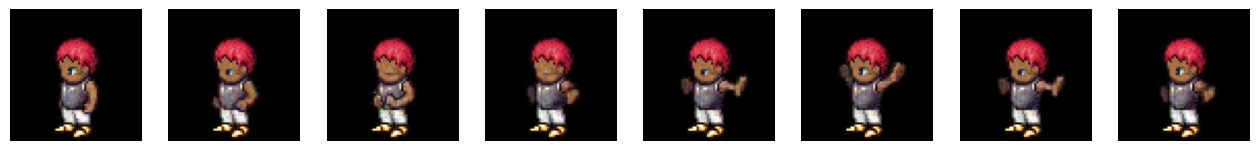

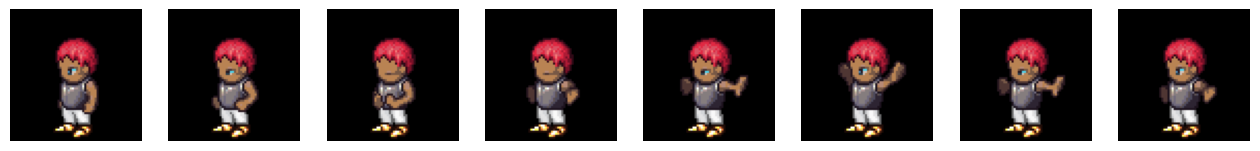

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([8, 3, 64, 64])


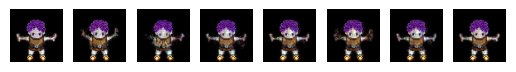

In [4]:
vae.eval()
rec = vae(train_dataset[0]).recon_x[0]
original = train_dataset[0].data
print(original.shape)
plt.figure(figsize=(16, 2))
for i in range(8):
    plt.subplot(1, 8, i+1)
    plt.imshow(rec[i].permute(1, 2, 0).detach().numpy())
    plt.axis('off')
plt.show()

plt.figure(figsize=(16, 10))
for i in range(8):
    plt.subplot(1, 8, i+1)
    plt.imshow(original[i].permute(1, 2, 0).detach().numpy())
    plt.axis('off')
plt.show()


z = torch.randn((1, latent_dim)).to('cpu')
out = vae.generate(z)[0].squeeze(0)
print(out.shape)
for i in range(vae.n_obs):
    plt.subplot(1, vae.n_obs, i+1)
    img = out[i].detach().cpu().numpy()
    plt.imshow(img.transpose(1, 2, 0))
    plt.axis('off')
plt.show()

In [5]:
########
in_channels = 3
out_channels = 3
channels = 64
n_res_blocks = 2
attention_levels = [2]
channel_multipliers = (1, 2, 4, 8, 16)
n_heads = 2

unet_config = {
    'in_channels': in_channels,
    'out_channels': out_channels,
    'channels': channels,
    'n_res_blocks': n_res_blocks,
    'attention_levels': attention_levels,
    'channel_multipliers': channel_multipliers,
    'n_heads': n_heads,
}

unet = load_config_unet(unet_config)
z = torch.randn(1, 3, 256, 256)
empty_prompt_embed = None
unet(z, torch.tensor([10]), empty_prompt_embed).shape

torch.Size([1, 3, 256, 256])